<a href="https://colab.research.google.com/github/yllari/Electric_stations/blob/main/Granada_gas_stations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The resulting maps are in "1.3. Map and driving distances" and "2. A more populated solution"

# 1. First approach, minimal

All the steps taken will try to fulfill the following conditions:


1.   Electric charging stations at less than 2 km of a highway
2.   No more than 50 km between stations
3.   Web-like structure (a network)


## 1.1.Data preprocessing

In [196]:
!pip install -qq overpy
import overpy

Using [Overpass API](https://wiki.openstreetmap.org/wiki/Overpass_API) to query locations that fulfill the given conditions.
In this case, the query is limited to only gas stations because there are more than enough to create the network and they already possess the desired infrastructure (enough space to park cars, etc). If needed, the query could be changed to include as many other locations as wanted.

In [197]:
api = overpy.Overpass()

# Query for all gas stations that are at less than road_distance=2km
# From a road classified as "autovía" (i.e motorway) in location=Granada
# Some other options for locations="Albacete, Galicia, Sevilla"

location = "Granada"
road_distance = "2000"  # (m)

response = api.query("""
[out:json];
area[name=""" + location + """]->.granada;
way[highway="motorway"](area.granada)->.roads;
nwr[amenity="fuel"](around.roads:""" + road_distance + """);
out center;""")

In [198]:
import pandas as pd

In [199]:
# Preparing the dataframe [id,latitude,longitude]
df = pd.DataFrame(
    columns=["id","lat","lon"])

for node in response.get_nodes():
    # Adding all the position information of nodes
    new_row = pd.DataFrame(
        {"id": node.id,
         "lat": node.lat,
         "lon": node.lon},
         index=[0])

    df = pd.concat([df,new_row],axis=0)

for way in response.get_ways():
    # Adding all the position information of ways
    new_row = pd.DataFrame(
        {"id": way.id,
         "lat": way.center_lat,
         "lon": way.center_lon},
         index=[0])

    df = pd.concat([df,new_row])

# Formatted information into a DataFrame, only for convenience
df.reset_index(inplace=True, drop=True)
print(df)

             id         lat         lon
0     251397642  37.1644508  -4.1684253
1     287007285  37.6467500  -2.0704000
2     287007637  37.5848967  -2.5830963
3     287007907  37.5957780  -2.4003890
4     287007967  37.4936930  -2.7751030
..          ...         ...         ...
189  1115340429  37.1543575  -3.6105574
190  1142220320  37.1216287  -3.6313156
191  1147915982  36.9494237  -3.5517101
192  1161327227  37.0282728  -3.6362339
193  1202820177  36.6989379  -3.4464416

[194 rows x 3 columns]


In [200]:
import matplotlib.pyplot as plt

Number of detected gas stations: 194


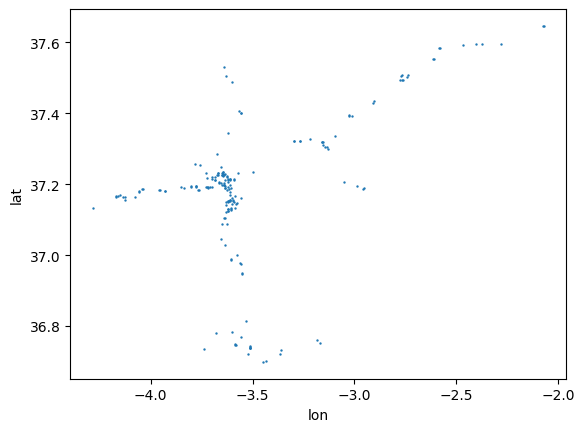

In [201]:
plt.scatter(x=df["lon"],y=df["lat"], s=0.5)
plt.xlabel("lon")
plt.ylabel("lat")
print("Number of detected gas stations:", len(df.index))

## 1.2.Algorithm

In [202]:
!pip install sklearn

In [203]:
import numpy as np
from sklearn.metrics.pairwise import haversine_distances
from math import radians

In [204]:
##
# dist_matrix(DataFrame : df)
# Estimate of distance between points on the surface of earth
##
def dist_matrix(df):
    earth_radius = 6371.0 #(km)

    converted = np.array([df["lat"].tolist(),df["lon"].tolist()],dtype=float)
    converted = np.deg2rad(converted.T)

    # This (ideally) would be a driving-distance using OSRM API, but setting up
    # the server would be time-consuming.
    # For simplicity, haversine distance (distance on a sphere) is used
    dist = haversine_distances(converted)
    return dist*earth_radius

Explanation of the algorithm:
Given a node, in this case a gas station $n_2$, check the two closest stations $n_1$ and $n_3$. These two points will be at a distance $d_{13}\equiv|n_1-n_3|$ with "$||$", whatever distance is used, such that
$d_{12}+d_{23}\geq d_{13}$ (Triangle inequality). Hence, 50 km>$d_{12}+d_{23}\implies$ 50 km $>d_{13}$. Then, we can surely erase that point without compromising the connection between those other stations. If instead of using 50 km we start with a smaller value and then increment it until we hit a threshold, we will eventually get a better, more evenly space map (the clumped stations will be erased first, then the further ones...)


<figure>
<center>
<img src="https://drive.google.com/uc?export=view&id=17VWBQS5eAU8XbsQT3zslOr-mx2KHsy8M
" alt="Distances diagram" width="200px">
</center>
</figure>



Put in simpler terms, we eliminate all possible points without disturbing the direct connection between all other gas stations (no larger distances than 50km). Thus, the result is an interconnected network structure that reduces the number of intermediate points (gas stations).

Of course, this is only possible if at first they were already "connected".

In [205]:
# Create copies to isolate this notebook cell
# Sampling to find different solutions depending seed, "random_state" is the seed
try_df = df.copy().sample(frac=1, random_state=44).reset_index(inplace=False,drop=True)
distances = dist_matrix(try_df)

# i will be a local counter, j will keep up with the DataFrame index
i=j=0
maxiter = len(distances)

# Control how limiting "limit" should be (smaller => stricter => more points)
# Since drive-distance >= haversine-distance, it is recommended to give some
# margin [0.,1.]
margin_factor = 1.

# maximum distance between gas stations
limit_radius = 50 #(km)

# Number of iterations, from 0.01 to margin_factor, "num_iters" steps
num_iters = 30

# Effective maximum distance
# Might need some tweaking, will depend of highway distances covered
# in the area
limit = limit_radius*margin_factor

# Iterate from smaller distances to larger
# Will create better and more evenly spaced maps


for m in np.linspace(0.01, margin_factor, num=num_iters):
  limit = m*limit_radius

  i=j=0
  maxiter = len(distances)
  try_df.reset_index(inplace=True, drop=True)

  while j < maxiter:
    # Checking (locally) if the distance between the two nearest points would be
    # Less than "limit" kms at max if the checked point is erased
    # If so, erase it from both DataFrame and matrix
    dist_mins = np.sort(distances[i])
    if ( (dist_mins[1] + dist_mins[2]) < limit):
      distances = np.delete(distances, i, axis=0)
      distances = np.delete(distances, i, axis=1)
      try_df.drop(j, inplace=True)
    else:
      i+=1
    j+=1

print("Resulting points: ", len(try_df.index))
print(f"All minimum haversine distances (strictly ≤{limit} km): ")
print(np.sort(distances)[:,1])

Resulting points:  12
All minimum haversine distances (strictly ≤50.0 km): 
[27.77128489 37.90391819 27.77128489 29.94687323 29.94687323 33.15678758
 20.23132913 20.23132913 30.62161742 29.40782413 33.47599221 48.5406695 ]


In [206]:
!pip install -qq folium

## 1.3.Map and driving distances

As shown in the map, using "margin_limit=1." gives a network with much space between stations. This is an approach for a minimal, yet web-like, solution.

In [207]:
import folium

def map_show(data : pd.DataFrame, loc_coords):

  # Create a map centered on loc_coords [latitude, longitude]
  map = folium.Map(location=loc_coords, zoom_start=8)

  # Loop through the data and add markers for each location
  for i, row in data.iterrows():
      folium.Marker([row['lat'], row['lon']],
                    popup=row['id']).add_to(map)
  return map

# Show the map
granada_map = map_show(try_df, loc_coords=[np.mean(try_df["lat"]), np.mean(try_df["lon"])])
granada_map

Now that fewer points are left, it is feasible to check the driving distances with the [OSRM API](http://project-osrm.org/docs/v5.5.1/api/) demo server.

In [208]:
# Let's check if the criteria is met for driving distance(<50km):
import requests
import json

Sending a query with the selected gas stations coordinates to OSRM API, an API desigend to calculate fastest driving distances (by car).

In [209]:
url = "http://router.project-osrm.org/table/v1/driving/"
routes = ""

# Query with longitude1,latitude1;longitude2,latitude2;...
for ind in try_df.index:
    routes += str(try_df["lon"][ind])+","+str(try_df["lat"][ind])+";"

routes = routes[:-1]

print("Query: ", routes[0:50]+"...")
routes_response = requests.get(url+routes+"?annotations=distance")

Query:  -2.9055092,37.4335891;-3.6375848,37.5298689;-2.958...


In [210]:
dist_table_json = routes_response.json()
try:
    dist_table=np.array(dist_table_json["distances"])/1000 # meters to km
except:
    print("Too big")

print(f"All minimum driving distances, should be approximately ≲{limit}: ",)
print(np.sort(dist_table)[:,1])
print("\nThere may be some driving distances exceeding the limit of "
      + f"{limit_radius} km, \n"
      + " this would not happen if all previous calculations were made with"
      + " this distance")

All minimum driving distances, should be approximately ≲50.0: 
[35.7167 58.9527 41.6493 33.2108 34.4654 52.3976 30.9149 30.8264 43.0503
 35.6136 40.9898 51.8688]

There may be some driving distances exceeding the limit of 50 km, 
 this would not happen if all previous calculations were made with this distance


# 2. A more populated solution (execute previous cells first)

Since the haversine distance approximation is better when dealing with smaller distances, the result for 50 km when comparing with driving distances is not that good. This is because 50 km represents a good portion of Granada's map (almost a 1/4 of the total length). We can do better by just reducing "margin_factor" to a smaller value, this will also increment the number of stations.

In [211]:
##### Copy-pasted code to better show the difference
try_df = df.copy().sample(frac=1, random_state=44).reset_index(inplace=False,drop=True)
distances = dist_matrix(try_df)

i=j=0
maxiter = len(distances)

margin_factor = 0.7 ### The only change

limit_radius = 50

num_iters = 30

limit = limit_radius*margin_factor

for m in np.linspace(0.01, margin_factor, num=num_iters):
  limit = m*limit_radius

  i=j=0
  maxiter = len(distances)
  try_df.reset_index(inplace=True, drop=True)

  while j < maxiter:
    dist_mins = np.sort(distances[i])
    if ( (dist_mins[1] + dist_mins[2]) < limit):
      distances = np.delete(distances, i, axis=0)
      distances = np.delete(distances, i, axis=1)
      try_df.drop(j, inplace=True)
    else:
      i+=1
    j+=1

print("Resulting points: ", len(try_df.index))
print(f"All minimum haversine distances (strictly ≤{limit} km): ")
print(np.sort(distances)[:,1])

granada_map = map_show(try_df, loc_coords=[np.mean(try_df["lat"]), np.mean(try_df["lon"])])
granada_map


Resulting points:  16
All minimum haversine distances (strictly ≤35.0 km): 
[27.06892778 19.39725385 16.93675414 16.09983292 28.55163172 31.97401251
 16.93675414 20.23132913 18.15976627 19.81635023 16.09983292 29.25886715
 20.26921845 19.39725385 27.06892778 19.26542611]


In [212]:
url = "http://router.project-osrm.org/table/v1/driving/"
routes = ""

for ind in try_df.index:
    routes += str(try_df["lon"][ind])+","+str(try_df["lat"][ind])+";"

routes = routes[:-1]

print("Query:", routes[0:50]+"... \n")
routes_response = requests.get(url+routes+"?annotations=distance")

dist_table_json = routes_response.json()
try:
    dist_table=np.array(dist_table_json["distances"])/1000
except:
    print("Too big")

print(f"All minimum driving distances, should be approximately ≲{limit}: ",)
print(np.sort(dist_table)[:,1])
print("\nThere may be some driving distances exceeding the limit of "
      + f"{limit_radius} km, \n"
      + " this would not happen if all previous calculations were made with"
      + " this distance")

Query: -2.9548330,37.1892500;-2.2810280,37.5957780;-3.357... 

All minimum driving distances, should be approximately ≲35.0: 
[41.2656 21.5768 20.2683 20.8804 39.9136 35.3761 20.2824 30.9149 30.8264
 35.7634 21.1499 30.706  23.6532 21.7719 32.8603 23.5717]

There may be some driving distances exceeding the limit of 50 km, 
 this would not happen if all previous calculations were made with this distance


Now everything checks out, and we have something that could be a network of electric car charging stations

# 3. Further improvements



1.   Using driving distance, would make better minimal solutions
2.   Apply more constraints depending on desired result

